In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
from datasets import load_dataset

ds = load_dataset("open-r1/codeforces-submissions", split="train", name="selected_accepted")

Resolving data files:   0%|          | 0/36 [00:00<?, ?it/s]

In [57]:
df = pd.DataFrame(ds)

In [58]:
print(df.head(10))

  submission_id                                             source contestId  \
0       4138797  #include <cstdio>\n#include <cmath>\nconst dou...         1   
1       4051974  #include <stdio.h>\n#include <math.h>\nconst d...         1   
2       4051971  #include<iostream>\n#include<cmath>\n#include<...         1   
3       3820194  #include<cstdio>\n#include<cmath>\n#define D d...         1   
4       3107569  #include<cstdio>\n#include<cmath>\n#define S(x...         1   
5     132362843  # -*- coding: utf-8 -*- \n# @project : 《Atcode...        10   
6     230994675  n = int(input())\na = list(map(int, input().sp...        10   
7      95059088  def lcis(a, b):\n    n, m = len(a), len(b)\n  ...        10   
8      75066752  """\ns1=input()\ns2=input()\nn=len(s1)\nm=len(...        10   
9      89312171  n=int(input())\nar=list(map(int,input().split(...        10   

  problem_index programmingLanguage verdict testset  passedTestCount  \
0             C             GNU C++      OK   T

In [59]:
df['label'] = df['timeConsumedMillis'].apply(lambda x: 1 if x >= 500 else 0)

print(df['label'].value_counts())

label
0    38528
1     3939
Name: count, dtype: int64


In [60]:
def feature_extraction(code):
  lines = code.count("\n") + 1
  loops = code.count("for") + code.count("while")
  funcs = code.count("def") + code.count('function') + code.count("{")
  imports = code.count("import") + code.count("#include")
  return [lines, loops, funcs, imports]

df[['lines_of_code', 'number_of_loops', 'number_of_functions', 'number_of_imports']] = df['og_source'].apply(lambda x: pd.Series(feature_extraction(str(x))))

In [61]:
from sklearn.model_selection import train_test_split

X = df[['lines_of_code', 'number_of_loops', 'number_of_functions', 'number_of_imports']]
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [62]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost Classifier": XGBClassifier(scale_pos_weight=10),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

#Model Evaluation without using SMOTE

In [63]:
def model_evaluation(models, X_train, y_train, X_test, y_test):
  results = []
  cm_dict = {}
  for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    results.append({
        "Model": name,
        "Accuracy": accuracy,
        "Precision(Fast)": report["0"]["precision"],
        "Recall(Fast)": report["0"]["recall"],
        "F1 Score(Fast)": report["0"]["f1-score"],
        "Precision(Slow)": report["1"]["precision"],
        "Recall(Slow)": report["1"]["recall"],
        "F1 Score(Slow)": report["1"]["f1-score"]
    })

    cm_dict[name] = cm
  return pd.DataFrame(results), cm_dict

In [64]:
results_without_smote, cm_without_smote = model_evaluation(models, X_train, y_train, X_test, y_test)
print("MODEL PERFORMANCE WITHOUT SMOTE")
print(results_without_smote)

MODEL PERFORMANCE WITHOUT SMOTE
                 Model  Accuracy  Precision(Fast)  Recall(Fast)  \
0        Random Forest  0.898634         0.917531      0.975993   
1   XGBoost Classifier  0.708265         0.952719      0.713859   
2  Logistic Regression  0.905698         0.909890      0.994550   

   F1 Score(Fast)  Precision(Slow)  Recall(Slow)  F1 Score(Slow)  
0        0.945859         0.377104      0.142132        0.206452  
1        0.816172         0.189338      0.653553        0.293615  
2        0.950338         0.408451      0.036802        0.067520  


#Model Evaluation with using SMOTE

In [65]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", y_train.value_counts())
print("After SMOTE:", y_train_smote.value_counts())

Before SMOTE: label
0    30822
1     3151
Name: count, dtype: int64
After SMOTE: label
0    30822
1    30822
Name: count, dtype: int64


In [66]:
results_with_smote, cm_with_smote = model_evaluation(models, X_train_smote, y_train_smote, X_test, y_test)
print("MODEL PERFORMANCE WITH SMOTE")
print(results_with_smote)

MODEL PERFORMANCE WITH SMOTE
                 Model  Accuracy  Precision(Fast)  Recall(Fast)  \
0        Random Forest  0.792442         0.934493      0.829354   
1   XGBoost Classifier  0.416294         0.974120      0.366338   
2  Logistic Regression  0.750648         0.946897      0.768233   

   F1 Score(Fast)  Precision(Slow)  Recall(Slow)  F1 Score(Slow)  
0        0.878790         0.205438      0.431472        0.278346  
1        0.532441         0.127412      0.904822        0.223371  
2        0.848259         0.203390      0.578680        0.300990  


#Plotting

In [71]:
def plot_confusion_matrix(cm_before, cm_after):
  plt.figure(figsize=(15, 12))
  i = 1
  for name in models.keys():
    #before SMOTE
    plt.subplot(3, 2, i)
    sns.heatmap(cm_before[name], annot=True, fmt="d", cmap="Blues", xticklabels=["Fast", "Slow"], yticklabels=["Fast", "Slow"])
    plt.title(f"{name} - Before SMOTE")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    i+=1


    #after SMOTE
    plt.subplot(3, 2, i)
    sns.heatmap(cm_after[name], annot=True, fmt="d", cmap="Greens", xticklabels=["Fast", "Slow"], yticklabels=["Fast", "Slow"])
    plt.title(f"{name} - After SMOTE")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    i+=1
  plt.tight_layout()
  plt.show()

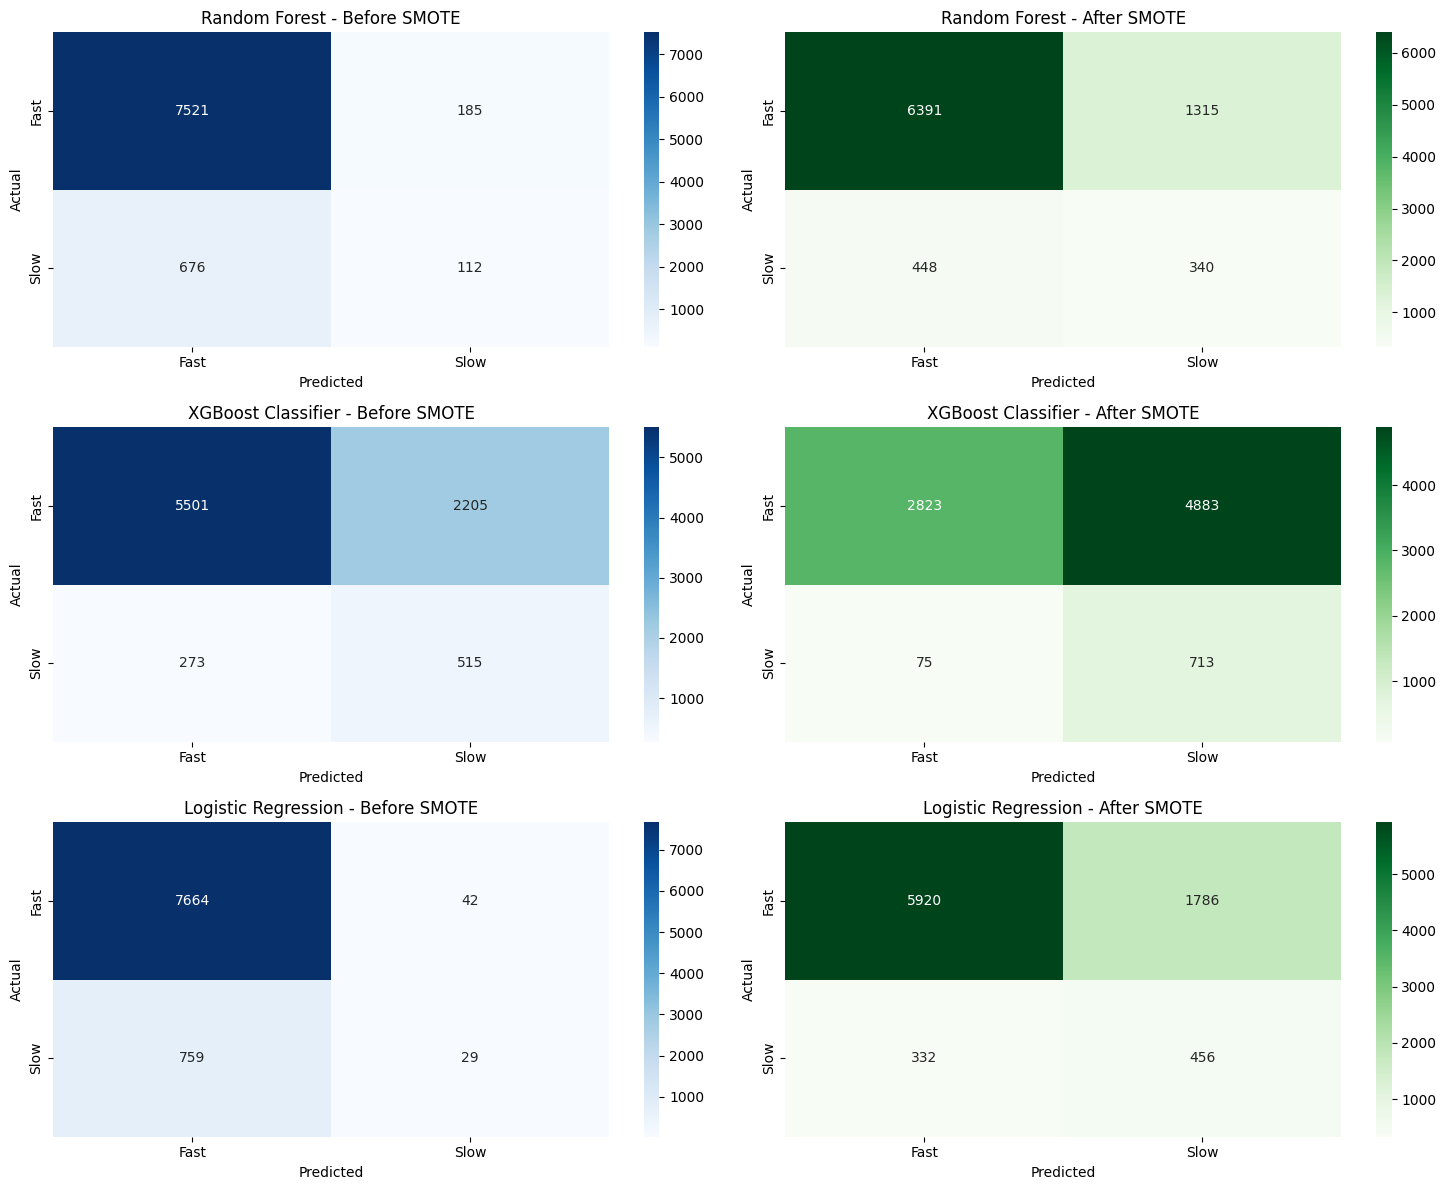

In [72]:
plot_confusion_matrix(cm_without_smote, cm_with_smote)